## Estimating gas temperature

We implement the modeling from Sharda+2023 to estimate gas temperature in our cloud models.

In [1]:
# Import packages and functions

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as units
from scipy import optimize
from scipy.interpolate import interp1d, NearestNDInterpolator
import warnings
import sys
import pandas as pd

from check_temp import find_Tdust_new, gastemp

# Constants
kmpers = 1e5 # convert km/s to cm/s
gcm2 = 0.000208836 # convert Msun / pc^2 to g / cm^2
pc = 3.086*1e18 # convert pc to cm
kappa = 1.5 # gas volume density PL power - rho(r) = rho0(r/r0)^-kappa
mu = 2.33 # mean molecular weight
u = 1.660538291 * 1e-24 # grams
mH = 1.007825 * u # hydrogen mass in g
userlogZ = 0 # log metallicity

# inputs / options for Sharda+2023 temperature estimates
userlogZ = 0
cosmicrays = 1
remyruyer = 0
H2formationheating = 1
chem = 0
coratio = 0
cosmicCrocker = 0
cosmicPadovani = 1 - cosmicCrocker

In [2]:
# extract CO cooling data and interpolate
COfile = np.genfromtxt("grid_COcooling_new.out")
log_nH = np.log10(COfile[:, 0])
Tgas = COfile[:, 1]
log_NCO = np.log10(COfile[:, 2])
sigma_v = COfile[:, 3] / 1e5
cooling_rate = COfile[:, 4]
COcooling = NearestNDInterpolator(list(zip(log_nH,Tgas,log_NCO,sigma_v)), cooling_rate)

In [3]:
# read in model subset from Sun+2020, Brunetti+2023, Brunetti+2024 catalogues used in Bemis+2024

df_out = pd.read_csv('model_subset300.csv')

# extract one 
example_gal = df_out.iloc[99]
print(example_gal)

Unnamed: 0     182169
Galaxy        NGC6744
scale            90.0
Sigma            11.0
Vdisp            2.69
alphavir        3.374
Name: 99, dtype: object


In [4]:
# Estimate mean density
Sigma_0 = example_gal['Sigma'] * units.M_sun/units.pc**2 # M_sun / pc^2
R_0 = example_gal['scale'] / 2 * units.pc # pc

# Use approximation to estimate volume density at surface / edge
rho_0 = (3 -  kappa) * Sigma_0 / R_0 / 4
n_0 = (rho_0 / (mH * units.g)).to(1/units.cm**3)

print(n_0)

3.707077726260633 1 / cm3


In [5]:
# Estimate surface dust temperature

# convert inputs into cgs units
usern = n_0.to(units.cm**-3).value
userR = R_0.to(units.cm).value
userSigma = Sigma_0.to(units.g/units.cm**2).value

solution = find_Tdust_new(usern, userR, userlogZ, kappa, remyruyer, userSigma)
Rch =  solution[2]
kT = solution[3]
Tdust = solution[4]
loguserdelta = solution[5]

print(Tdust*units.K)

5.673943748640975 K


In [6]:
# estimate gas temperature over array of radii, gas densities

# radius and density arrays
minR = np.log10(0.001 * units.pc.to(units.cm))
maxR = np.log10(userR)
R_gas = np.logspace(minR, maxR,10)
n_gas = usern * (R_gas/userR)**-kappa

rho_ex = rho_0.to(units.kg/units.cm**3).value * units.kg.to(units.g)
vdisp_ex = example_gal['Vdisp'] * (units.km /units.s).to(units.cm/units.s)

# Initial guess
Tgasguess = 30.
        
Tgas = []
for r, n  in zip(R_gas,n_gas):

    Tg = optimize.root(lambda t: gastemp(t, r, COcooling, rho_ex, userR, kappa, coratio, chem, cosmicrays, cosmicCrocker, cosmicPadovani, userSigma, Tdust, kT, vdisp_ex, loguserdelta, H2formationheating, usern), x0=Tgasguess, method='linearmixing')
    Tgas.append(float(Tg.x))

print(Tgas)

[97.95640227792978, 50.69944078547136, 34.993778189813064, 22.498368334798904, 12.434589055989925, 12.499869872147189, 17.504134075615205, 101.27294007753993, 122.7112797636818, 135.2330725149018]


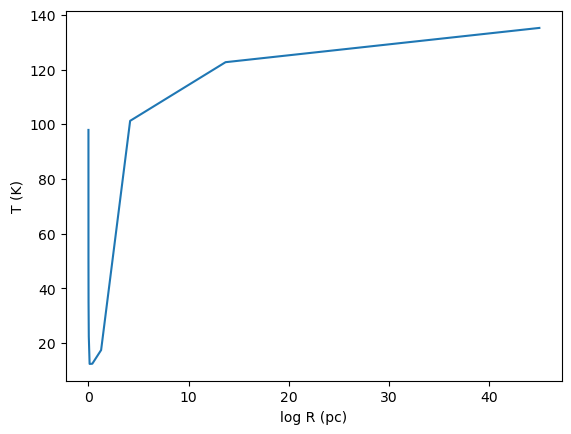

In [7]:
plt.plot(R_gas/pc, Tgas)
plt.xlabel("log R (pc)")
plt.ylabel("T (K)")
plt.show()